# pyPanair Tutorial#1 Rectangular Wing  
In this tutorial we will perform an analysis of a rectangular wing with a NACA0012 airfoil.  
A brief overview of the procedure is listed below:  
1. Define the geometry of the wing using `wgs_creator.py`, and create input files `naca0012.wgs` and `naca0012.aux` for `panin`
2. Using the preprocessor `panin`, create an input file `a502.in` for `panair`
3. Run the analysis
4. Visualize the results from the analysis via `agps_converter.py`, `ffmf_converter.py`, and `calc_section_force.py`

## 1. Defining the geometry
### 1.1 LaWGS Format
First off, we will begin by defining the geometry of the rectangular wing.

The input geometry for `panair` (or more precisely, its preprocessor `panin`) is defined in the Langley Wireframe Geometry Standard (LaWGS) format. The format is described in [reference 1](https://ntrs.nasa.gov/search.jsp?R=19850014069).  

In a nutshell, LaWGS files are a bundle of 3 dimensional arrays, which are referred to as "networks". A network is composed of "lines", which in turn is composed of 3-dimensional "points". If a network has `m` lines, and each line of has `n` points, the shape of the corresponding 3d array will be `(m, n, 3)`. Below is an example of a LaWGS file for a delta wing.

```sample1.wgs
deltawing created from wgs_creator
wing
1 3 5 0   0 0 0   0 0 0    1 1 1  0
1.0000000e+01 0.0000000e+00 0.0000000e+00
5.0000000e+00 0.0000000e+00 1.0000000e+00
0.0000000e+00 0.0000000e+00 0.0000000e+00
5.0000000e+00 0.0000000e+00 -1.0000000e+00
1.0000000e+01 0.0000000e+00 0.0000000e+00
7.5000000e+00 1.0000000e+01 0.0000000e+00
5.0000000e+00 1.0000000e+01 5.0000000e-01
2.5000000e+00 1.0000000e+01 0.0000000e+00
5.0000000e+00 1.0000000e+01 -5.0000000e-01
7.5000000e+00 1.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
```

The first row displays the title of the LaWGS file.
```
deltawing created from wgs_creator
```

The second row displays the name of the network.
```
wing
```

The third row lists the parameters of the network.
```
1 3 5 0   0 0 0   0 0 0    1 1 1  0
```
The definitions of the first three numbers are as follows:
* "1": the id of the network
* "3": the number of lines in the network
* "5": the number of points in each line

The remaining 11 numbers, `0   0 0 0   0 0 0    1 1 1  0`, define the local and global axes. (Read reference 1 for more information.)  

The fourth and subsequent lines, define the coordinates of each point. For example, the fourth line, `1.0000000e+01 0.0000000e+00 0.0000000e+00`, means that the coordinate of the first point is `x=1., y=0., z=0.`.

The wireframe defined by the above file looks like this ...

<IPython.core.display.Javascript object>


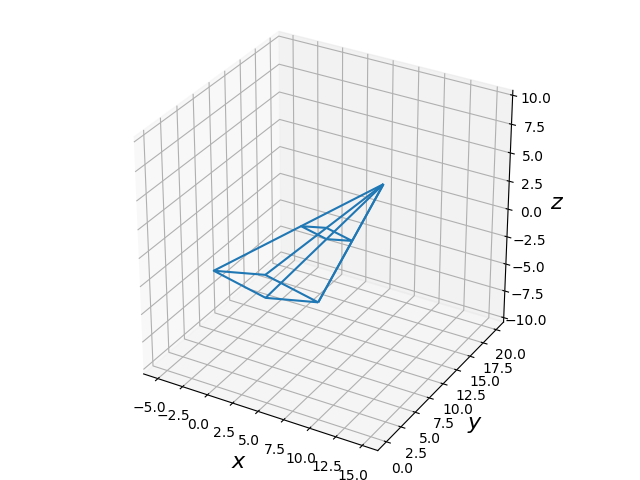

In [18]:
%matplotlib notebook
from pyPanair.preprocess import wgs_creator
delta_wing = wgs_creator.read_wgs("sample1.wgs")
delta_wing._networks[0].plot_wireframe(show_normvec=False, show_corners=False, show_edges=False)

### 1.2 Creating a LaWGS file using pyPanair
Next, we will create a LaWGS file using the `wgs_creator` module of `pyPanair`. In the `wgs_creator` module, LaWGS files are created using objects that derive from the four classes, `LaWGS`, `Network`, `Line`, and `Point`. A brief explanation of these classes are written below.  
* `LaWGS`: A class that represents a LaWGS format geometry as a list of `Networks`. Can be used to read/write LaWGS files.
* `Network`: A class that represents a network as a 3-dimensional array.
* `Line`: A class that represents a line as a 2-dimensional array.
* `Point`: A class that represents the xyz coordinates of a point. A 1-dimensional array is used to define the coordinates.

Now we will begin the actual work of creating a LaWGS file. First, we start of by initializing a `LaWGS` object. The title of the LaWGS object will be `"NACA0012"`.

In [2]:
wgs = wgs_creator.LaWGS("NACA0012")

In the next step, the `Network` of the wing will be defined by interpolating two `Lines`, the `root_airfoil` and `tip_airfoil`. The `root_airfoil`, which is an NACA0012 airfoil, can be constructed using the `naca4digit` method.  

In [3]:
root_airfoil = wgs_creator.naca4digit("0012", num=25, chord=100., span_pos=0.)

The resulting airfoil has a chord length of `100.`, and its spanwise position (e.g. y-axis coordinate) is `0.`.
The upper and lower surfaces are each represented with `25` points.
The x and z coordinates of the airfoil look like below:

<IPython.core.display.Javascript object>


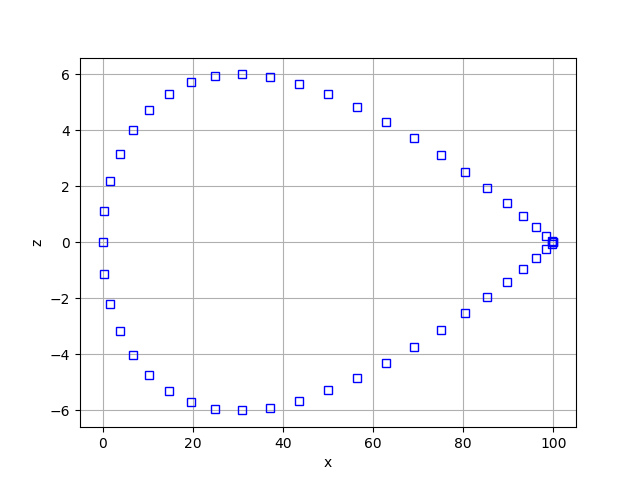

In [19]:
import matplotlib.pyplot as plt
plt.plot(root_airfoil[:,0], root_airfoil[:,2], "s", mfc="None", mec="b")
plt.xlabel("x")
plt.ylabel("z")
plt.grid()
plt.show()

The `tip_airfoil` can be defined in the same manner as the `root_airfoil`.
However, this time, the spanwise position will be `span_pos=300.`.

In [5]:
tip_airfoil = wgs_creator.naca4digit("0012", num=25, chord=100., span_pos=300.)

The `Network` of the wing will be defined by interpolating to the two `Lines`, `root_airfoil` and `tip_airfoil`.
To do so, we simply use the `linspace` method.

In [6]:
wing = root_airfoil.linspace(tip_airfoil, num=20)

The wing `Network` will have `20` lines, which are linear interpolations of the `root_airfoil` and `tip_airfoil`.
`Networks` can be visualized using the `plot_wireframe` method.

<IPython.core.display.Javascript object>


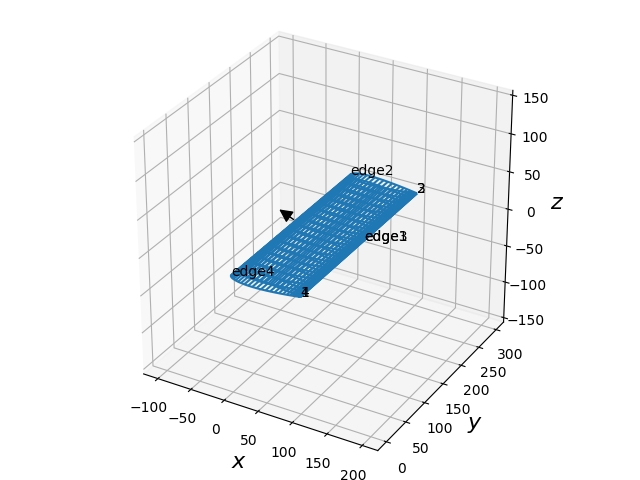

In [7]:
wing.plot_wireframe()

Along with coordinates of each point in the `Network`, the corners (e.g. `1`) and edges (e.g. `edge1`) are displayed.
(Read reference 1 for more information on network corners and edges.)
Also, an arrow indicating the front side of the network is depicted.
(Details of "front side" will be mentioned later.)



After defining the `Network` for the wing, we register it to `wgs`.

In [8]:
wgs.append_network("wing", wing, boun_type=1)

The first variable, `"wing"`, is the name of the network.
The second variable, `wing`, is the `Network` we are registering.
The third variable, `1`, is the boundary type of the network. If the network represents a solid wall, the type is `1`.
(Read [reference 2](https://docs.google.com/file/d/0B2UKsBO-ZMVgS1k5VElNamx1cUk/edit) for more information on the different types of boundary conditions.)

The next process will be to define the geometry of the wingtip.
To do so, we will split the `tip_airfoil` into upper and lower halves, and linearly interpolate them.
All of this can be done by typing

In [9]:
wingtip_upper, wingtip_lower = tip_airfoil.split_half()
wingtip_lower = wingtip_lower.flip()
wingtip = wingtip_upper.linspace(wingtip_lower, num = 5)

The wing tip will look like ...

<IPython.core.display.Javascript object>


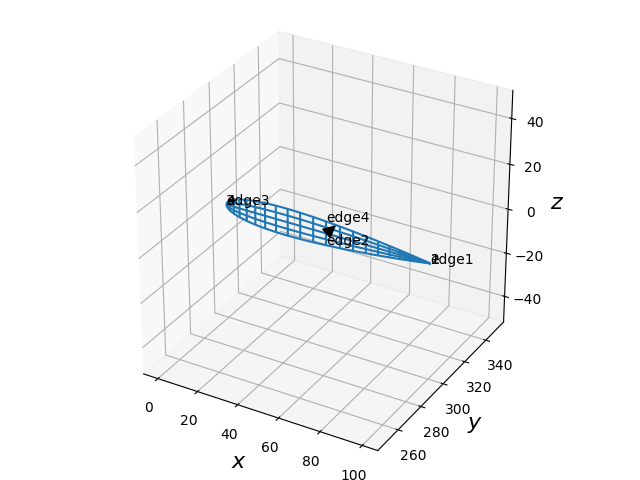

In [10]:
wingtip.plot_wireframe()

The `wingtip` will also be registered to `wgs`.

In [11]:
wgs.append_network("wingtip", wingtip, 1)

In addition to the `wing` and `wingtip`, we also must define the "wake" of the wing.
In `Panair`, the wake is defined as a square network stretching out from the trailing edge of the wing.
The length of the wake should be about 25 to 50 times the length of the reference chord of the wing.
The wake can be easily defined by using the method `make_wake`.

In [12]:
wingwake = wing.make_wake(edge_number=3, wake_length=50*100.)

The `edge_number` variable, means that we are attaching the wake to `edge3` of the `Network` `wing`.  
The `wake_length` variable defines how long the wake is.
In this case, the wake stretches from `x=100.` (the TE of the wing) to `x=5000.`.  

The `wingwake` will also be registered to `wgs`.

In [13]:
wgs.append_network("wingwake", wingwake, 18)

Notice that this time we are setting the boundary type as `18`.
Boundary type `18` is used to define the that network is a "wake" emitted from sharp edges.

Now that we have finished defining the geometry of the rectangular wing,
we will check to see if there are any errors in the model we've constructed.

To make this task easy, we will write the geometry into a STL (STereoLithography) format.
To do so, type

In [14]:
wgs.create_stl("naca0012.stl")

A stl file named `naca0012.stl` should be created in the current working directory.
Open this file with a stl viewer. (I recommend [Materialise MiniMagics 3.0](http://www.materialise.co.jp/minimagics-stl-viewer-0))

Below is a screen shot of the stl.

![stl_screenshot](stl_screenshot.png)

Using the stl viewer, we should watch out for the following four points:

1. The stl model is watertight (e.g. No holes between each network)
2. There are no intersecting networks (e.g. No networks crossing over each other)
3. The front side of the network (excluding the wake network) is facing outwards.  
In the picture above, the grey side of the stl (which correspond to the front side of the networks) is facing the flow.
4. The corners of each network abut on corners from other networks

If you've followed the instructions, the `naca0012.stl` should fulfill all four points. (If not try again.)

Finally, we will write the input files for `panin`.
This can be accomplished, using the methods, `write_wgs` and `write_aux`.

In [15]:
wgs.create_wgs("naca0012.wgs")
wgs.create_aux("naca0012.aux", alpha=6, mach=0.2, cbar=100., span=600.,
               sref=60000., xref=25., zref=0.)

Two files, `naca0012.wgs` and `naca0012.aux` should be crated in the current directory.  
`naca0012.wgs` is a file that defines the geometry of the model.  
`naca0012.aux` is a file that defines the analysis conditions.  
The definition of each variable is listed below: 
* `alpha`: The angle of attack (AoA) of the analysis.  
When conducting multiple cases, the variable should be a tuple defining the AoAs. (e.g. `(2, 4, 6, 8)`) 
Up to four cases can be conducted in one run.
* `mach`: The mach number of the flow
* `cbar`: The reference chord of the wing
* `span`: The reference span of the wing
* `sref`: The reference area of the wing
* `xref`: The x-axis coordinate of the center of rotation
* `zref`: The z-axis coordinate of the center of rotation

## 2. Creating an input file for `panair`

In this chapter we will create an input file for `panair`, using its preprocessor `panin`.  

If you do not have a copy of `panin`, download it from [PDAS](http://www.pdas.com/panin.html), and compile it.  
(I'm using cygwin, so the code blocks below are for cygwin environment.)

```bash
gfortran -o panin.exe panin.f90
```

After compiling `panin`, place `panin.exe`, `naca0012.wgs`, and `naca0012.aux` under the `tutorial1/panin/` directory.  
Then run `panin`.

```bash
./panin
```

It will display
```bash
 Prepare input for PanAir
  Version 1.0 (4Jan2000)
 Ralph L. Carmichael, Public Domain Aeronautical Software
 Enter the name of the auxiliary file: 
```

Enter `naca0012.aux`. If everything goes fine, it should display
```bash
          10  records copied from auxiliary file.
           9  records in the internal data file.
  Geometry data to be read from NACA0012.wgs                                                                    
 Reading WGS file...
 Reading network wing
 Reading network wingtip
 Reading network wingwake
 Reading input file instructions...
 Command  1 MACH 0.2
 Command 11 ALPHA 6
 Command  6 cbar 100.0
 Command  7 span 600.0
 Command  2 sref 60000.0
 Command  3 xref 25.0
 Command  5 zref 0.0
 Command 35 BOUN 1 1 18
 Writing PanAir input file...
  Files a502.in added to your directory.
 Also, file panin.dbg
 Normal termination of panin, version 1.0 (4Jan2000)
 Normal termination of panin
```

and `a502.in` (an input file for `panair`) should be created under the current directory.


## 3. Running `panair`

Now its time to run the analysis.  
If you do not have a copy of `panair`, download it from [PDAS](http://www.pdas.com/panair.html), and compile it.
(A bunch of warnings will appear, but it should work.)

```bash
gfortran -o panair.exe -Ofast -march=native panair.f90
```

Place `panair.exe` and `a502.in` under the `tutorial1/panair/` directory, and run `panair`.

```bash
./panair
```

`panair` will display the below text.

```bash
 Panair High Order Panel Code, Version 15.0 (10 December 2009)
 Enter name of input file:
```

Enter `a502.in`. The analysis will end in a few seconds.  
After the analysis ends, the output files such as , `panair.out`, `agps`, and `ffmf` will be created in the current directory.  

`panair.out` contains the output of the whole analysis (e.g. source and doublet strength of each panel)  
`agps` contains the surface pressure distribution for each case  
`ffmf` contains the aerodynamic coefficients for each case  

* Warning: Along with the output files, you will also notice the existence of intermediate files (e.g. `rwms01`).  
Users should always delete these intermediate files when running new cases.  
(To do so, run `clean502.bat` or `clean502.sh` which is contained in the archive file `panair.zip`)

## 4. Visualizing the output

### 4.1 Validation

In this chapter we will visualize the results of the analysis, but before we do so, we will validate the results by checking the aerodynamic coefficients.  

Open the `ffmf` file contained in the `tutorial1/panair/` directory with a text editor.  
After the headers of the file, you shall see 

```
 sol-no     alpha      beta            cl           cdi            cy            fx            fy            fz
                                                                                 mx            my            mz            area
 ------   -------   -------       -------       -------     ---------     ---------     ---------     ---------    ------------

      1    6.0000    0.0000       0.47852       0.01266       0.00000      -0.03743       0.00000       0.47723
                                                                            0.00000       0.00203       0.00000    123954.39335
```

This area shows the aerodynamic coefficients of each case.  
A brief explanation of each column is listed below:  

* `sol-no`: The case number
* `alpha`: The AoA of the case
* `beta`: The side slip angle of the case
* `cl`: The lift coefficient of the entire geometry
* `cdi`: The induced drag coefficient of the entire geometry
* `cy`: The side force coefficient of the entire geometry
* `fx, fy, fz`: The non-dimensional force in x, y, z direction, respectively
* `mx, my, mz`: The non-dimensional torque in x, y, z direction, respectively

Notice that `cl` and `fz` do not match.
This is because, `cl` is obtained from a trefz plane analysis, whereas `fz` is obtained by integrating the surface pressure of the geometry.
The same can be said for `cdi` and `fx`.

According to the lifiting line theory<sup>(3</sup>, when the AoA is $\alpha\mathrm{[rad]}$, the lift coefficient ($C_L$) and induced drag coefficient ($C_{D_i}$) for a untwisted uncambered rectangular wing with an aspect ratio of $6$ is 
$$C_L = 0.9160\frac{\pi^2}{2}\alpha$$
$$C_{D_i} = 0.8744\frac{\pi^3}{24}\alpha^2$$
In our analysis, the AoA is $0.1047 \mathrm{[rad]}$, so the lift and drag coefficients should be $C_L = 0.4734$ and $C_{D_i} = 0.01239$.  
The analysis predicted a fairly close value of $C_L = 0.4785$ and $C_{D_i} = 0.01266$.  

### 4.2 Visualization of the surface pressure distribution

Now we shall move on to the visualization of the result.  

First, we begin by converting the `agps` file into a format that can be used in common visualization applications.  
The `agps` file can be converted into three formats:
  
1. `vtk`: Legacy paraview format  
2. `vtu`: Multi-block paraview format  
3. `dat`: Multi-block tecplot format

In this tutorial we choose the `vtk` format.
To convert the `agps` file, first move the `agps` file to the `tutorial1/` directory.  
Then, use the `write_vtk` method of `pyPanair`.  (If you wish to use tecplot, enter `write_tec` instead of `write_vtk`.)  

In [16]:
from pyPanair.postprocess import write_vtk
write_vtk(n_wake=1)

n_wake =  1
network 1 shape:  (20, 49, 5)
network 2 shape:  (5, 25, 5)


(The `n_wake` variable is used to input the number of wakes. 
For example, if we enter `2`, the last `2` networks in the geometry will not be included in the output `vtk` file.)

`agps.vtk` should be created in the current directory, which can be open with [ParaView](http://www.paraview.org/).  

Below is a screen shot of ParaView.  

![paraview_screenshot](paraview_screenshot.png)

We can precieve that the flow on the upper surface is accelerated near the leading edge of the wing.  

### 4.3 Visualization of the local lift coefficient
 
Next, we calculate the local lift coefficient from the surface pressure distribution.  
This can be done using the `section_force` method.

In [17]:
from pyPanair.postprocess import calc_section_force
calc_section_force(aoa=6, mac=100., rot_center=(25,0,0), casenum=1, networknum=1)

The definition of each variable is as follows:  

* `aoa`: The AoA of the case
* `mac`: The mean aerodynamic chord of the wing
* `rot_center`: The xyz-axis coordinates of the center of rotation
* `casenum`: The case number of the analysis (e.g. `2` if the `sol-num` for the case is `2` in `ffmf`)
* `networknum`: The network number of the wing (e.g. `1` if the wing is first network in the LaWGS file)

`section_force.csv` should be created in the current directory.
To visualize it, we will use `pandas`.

In [24]:
import pandas as pd
section_force = pd.read_csv("section_force.csv")
section_force

,pos,cd,cl,cm
0,0.0000,0.012108,0.570044,-0.002501
1,15.7895,0.012308,0.568941,-0.003652
2,31.5789,0.012342,0.567785,-0.003226
3,47.3684,0.012360,0.565642,-0.003110
4,63.1579,0.012420,0.562573,-0.002946
5,78.9474,0.012493,0.558507,-0.002726
6,94.7368,0.012579,0.553340,-0.002441
7,110.5260,0.012675,0.546936,-0.002080
8,126.3160,0.012775,0.539117,-0.001629
9,142.1050,0.012873,0.529645,-0.001068


<IPython.core.display.Javascript object>


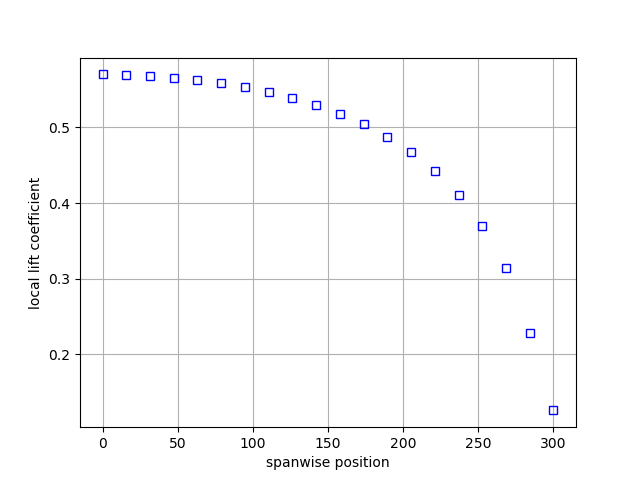

In [26]:
plt.plot(section_force.pos, section_force.cl, "s", mfc="None", mec="b")
plt.xlabel("spanwise position")
plt.ylabel("local lift coefficient")
plt.grid()
plt.show()

We can see how the local lift coefficient takes the highest value at the root of the wing and decreases as it get closer to the tip of the wing.  
This is a characteristic of the local lft coefficient distribution for a untwisted rectangular wing.

This will be the end of tutorial 1. 

### References
1. Craidon, C. B., "A Description of the Langley Wireframe Geometry Standard (LaWgs) Format," *NASA TM 85767*, 1985.
2. Saaris, G. R., "A502I User's Guide-PAN AIR Technology Program for Solving Potential Flow about Arbitrary Configurations," 1992.
3. Moran, J., *An Introduction to Theoretical and Computational Aerodynamics*, John Wiley & Sons, Inc., 1984.